In [1]:
import joblib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np

import os
os.chdir('../src')

from specs import m_to_label, downstream_scores, layer_map, assign_color
from plot_utils import make_correlation_plot, load_results, make_barplot, layerwise_rsa

### Gather results

In [2]:
#Run this cell if not calculated yet...
results_df = load_results('../from_scratch')
results_df.to_csv('results.csv')

0it [00:04, ?it/s]


KeyboardInterrupt: 

In [10]:
#Else, just read the precalculated results
results_df = pd.read_csv('results.csv')

all_models_layer_rsa = []
for m in layer_map.keys():
    data = layerwise_rsa('../rdm_layerwise', m)
    data['rsa_b2021_max'] = max(data['lw_B2021']) if data['lw_B2021'] is not None else None
    data['rsa_nh2015_max'] = max(data['lw_NH2015']) if data['lw_NH2015'] is not None else None
    data['rsa_b2021_se'] = data['lw_std_B2021'][np.argmax(data['lw_B2021'])] if data['lw_B2021'] is not None else None
    data['rsa_nh2015_se'] = data['lw_std_NH2015'][np.argmax(data['lw_NH2015'])] if data['lw_NH2015'] is not None else None
    all_models_layer_rsa.append(data)

df_layerwise_rsa = pd.DataFrame(all_models_layer_rsa)
results_df = pd.merge(df_layerwise_rsa, results_df, left_on='model', right_on='model', how='right')

### Regression results

rsa_B2021_mean
rsa_B2021_se
rsa_NH2015_mean
rsa_NH2015_se


<Figure size 640x480 with 0 Axes>

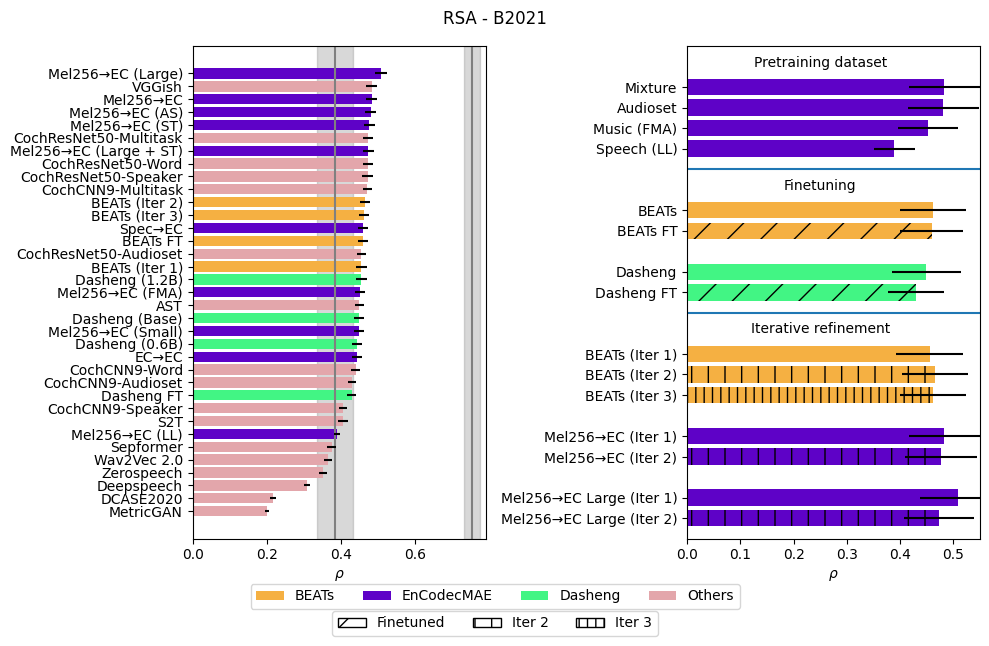

<Figure size 640x480 with 0 Axes>

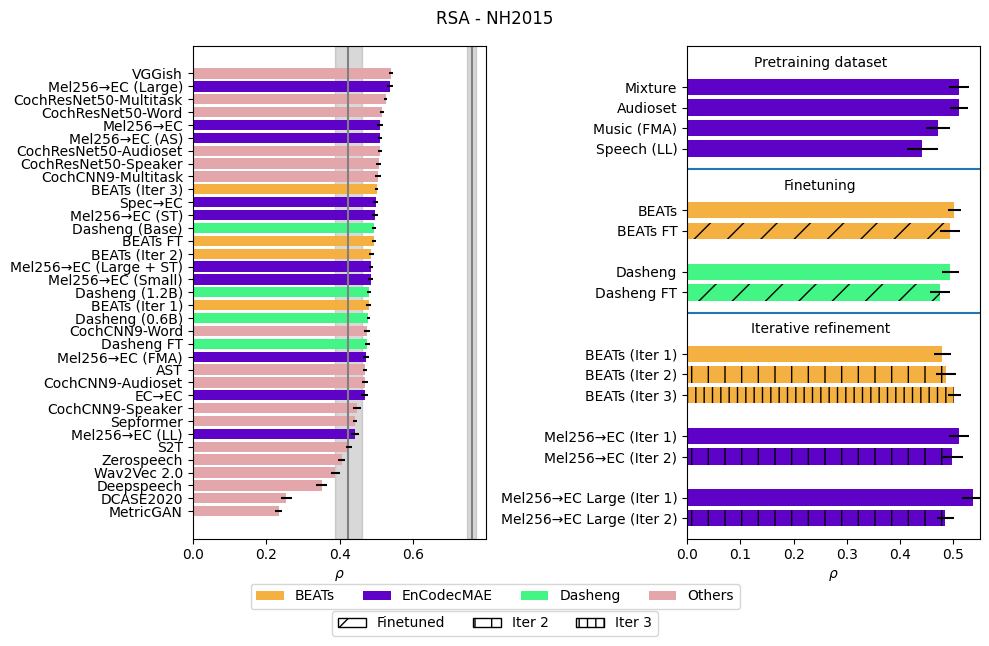

<Figure size 640x480 with 0 Axes>

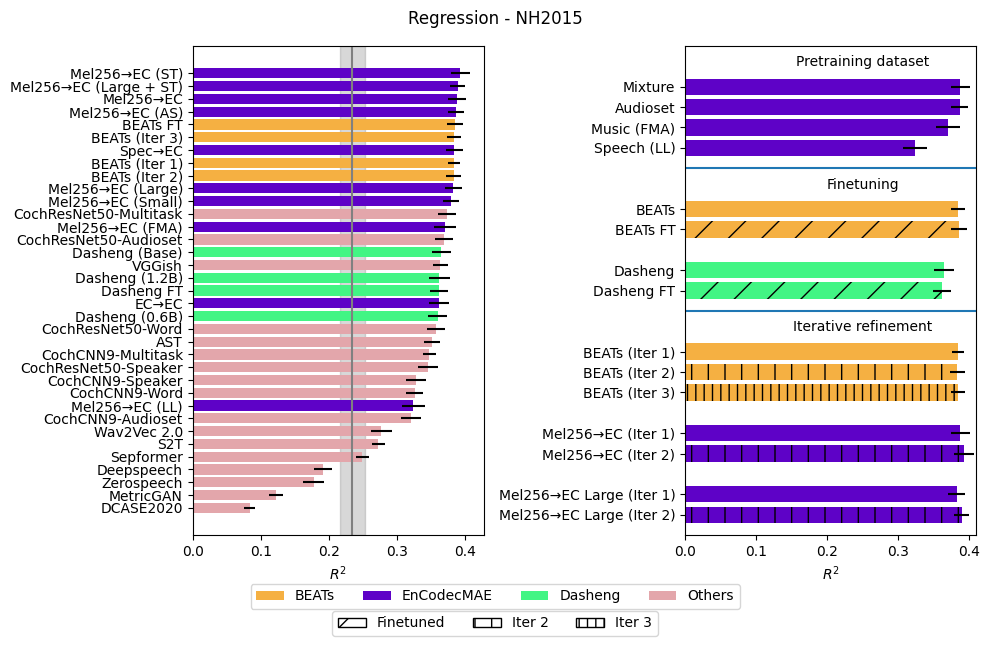

In [12]:
plt.figure()
make_barplot(results_df, 'rsa_b2021_max', xlabel=r'$\rho$')
plt.suptitle('RSA - B2021')
plt.tight_layout()
plt.savefig('rsa_b2021_lw.pdf', bbox_inches="tight")

plt.figure()
make_barplot(results_df, 'rsa_nh2015_max', xlabel=r'$\rho$')
plt.suptitle('RSA - NH2015')
plt.tight_layout()
plt.savefig('rsa_nh2015_lw.pdf', bbox_inches="tight")

plt.figure()
make_barplot(results_df, 'REG_NH2015_mean', topline=False, xlim=0.41)
plt.suptitle('Regression - NH2015')
plt.tight_layout()
plt.savefig('reg_nh2015.pdf', bbox_inches="tight")

### Per Layer RSA

Text(0, 0.5, '$\\rho$ - RDM Cross Validation')

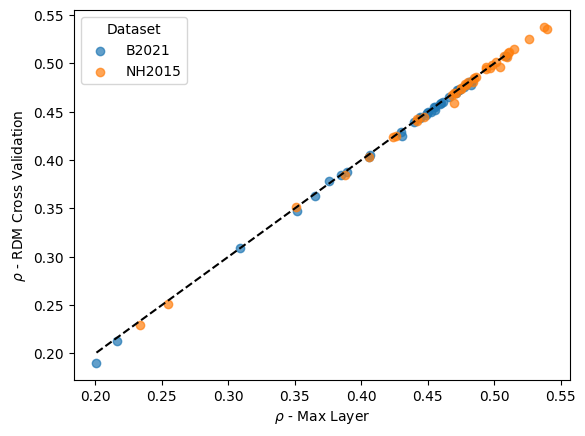

In [25]:
x1 = results_df['rsa_b2021_max'].values
y1 = results_df['rsa_B2021_mean'].values

x2 = results_df['rsa_nh2015_max'].values
y2 = results_df['rsa_NH2015_mean'].values

plt.scatter(x1, y1, alpha=0.7, label='B2021')
plt.scatter(x2, y2, alpha=0.7, label='NH2015')
plt.plot(np.linspace(x1.min(), x1.max(), 20), np.linspace(x1.min(), x1.max(), 20), 'k--')

plt.legend(title='Dataset')
plt.xlabel(r'$\rho$ - Max Layer')
plt.ylabel(r'$\rho$ - RDM Cross Validation')

### RSA vs Regression

Text(0, 0.5, '$\\rho$')

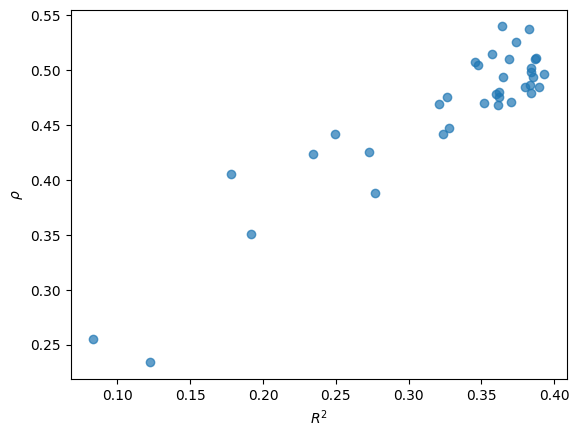

In [26]:
x1 = results_df['REG_NH2015_mean'].values
y1 = results_df['rsa_nh2015_max'].values


plt.scatter(x1, y1, alpha=0.7)
#plt.plot(np.linspace(x1.min(), x1.max(), 20), np.linspace(x1.min(), x1.max(), 20), 'k--')

plt.xlabel(r'$R^2$')
plt.ylabel(r'$\rho$')

Text(0, 0.5, '$\\rho - NH2015$')

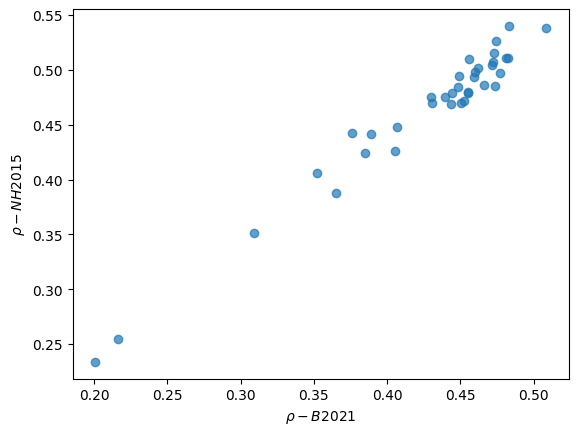

In [27]:
x1 = results_df['rsa_b2021_max'].values
y1 = results_df['rsa_nh2015_max'].values


plt.scatter(x1, y1, alpha=0.7)
#plt.plot(np.linspace(x1.min(), x1.max(), 20), np.linspace(x1.min(), x1.max(), 20), 'k--')

plt.xlabel(r'$\rho - B2021$')
plt.ylabel(r'$\rho - NH2015$')

### Components prediction

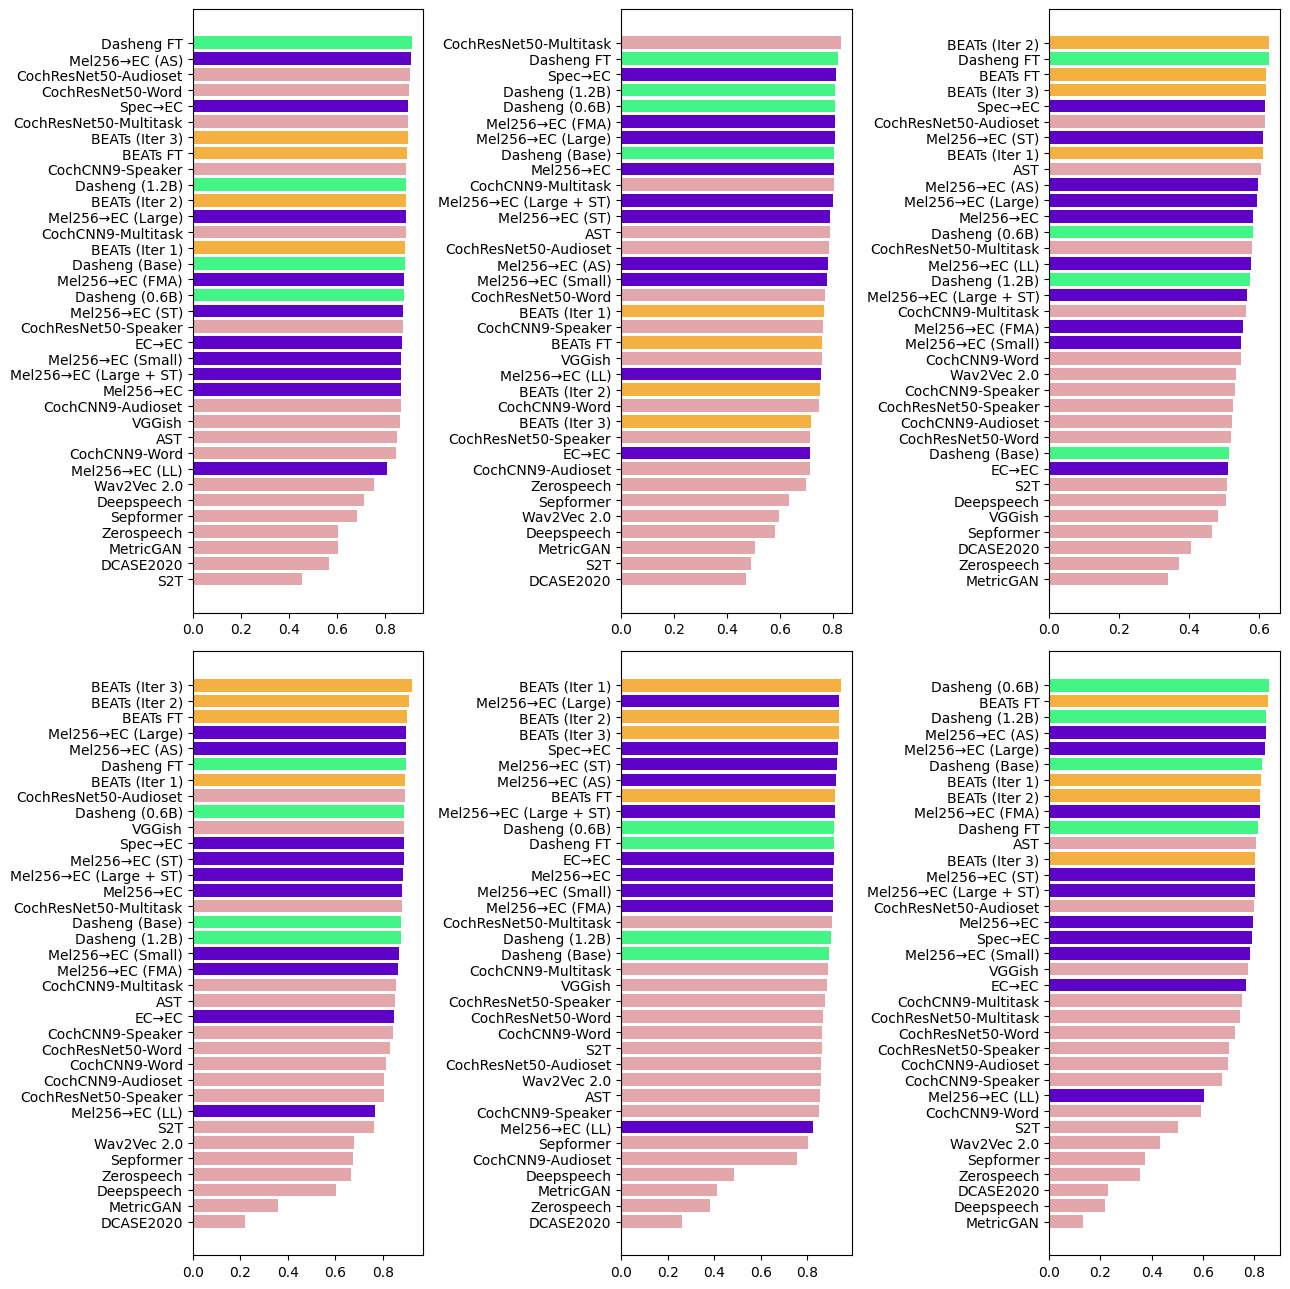

In [38]:
cols_comp = [f'REG_NH2015comp_{i}' for i in range(6)]
comp_data = results_df.set_index('model')
comp_data = comp_data[cols_comp]
comp_data = comp_data.loc[comp_data.index.map(lambda x: x!='topline')]

fig, ax = plt.subplots(figsize=(13,13), nrows=2, ncols=3)
for i,c in enumerate(cols_comp):
    comp_i = comp_data[c].sort_values(ascending=True)
    spec = comp_i.loc['braindnn_spectemp_filters']
    comp_i = comp_i.drop(index='braindnn_spectemp_filters')
    ax[i//3,i%3].barh(y=comp_i.index.map(lambda x: m_to_label[x]), 
                      width=comp_i.values,
                      color=comp_i.index.map(lambda x: assign_color(x, segment_cochdnn=False)))
plt.tight_layout()

In [25]:
comp_i

model
dasheng_06B                                0.859815
BEATs_iter3_finetuned_on_AS2M_cpt1         0.856503
dasheng_12B                                0.849606
mel256-ec-base-as                          0.849244
mel256-ec-large                            0.844491
dasheng_base                               0.832997
BEATs_iter1                                0.828611
BEATs_iter2                                0.825249
mel256-ec-base-fma                         0.823485
dasheng_base_ft-as                         0.817333
braindnn_ast                               0.807617
BEATs_iter3                                0.805442
mel256-ec-base_st-nopn                     0.805158
mel256-ec-large_st-nopn                    0.803581
braindnn_resnet50_audioset                 0.799753
mel256-ec-base                             0.795903
spec-ec-base                               0.794553
mel256-ec-small                            0.783439
braindnn_vggish                            0.777877
ec-ec-

### Downstream vs Alignment

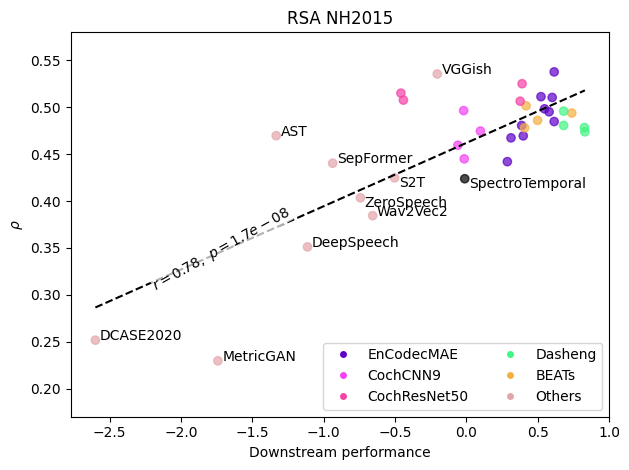

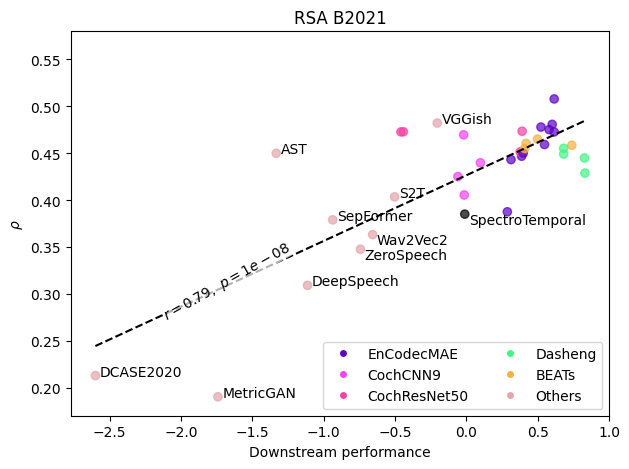

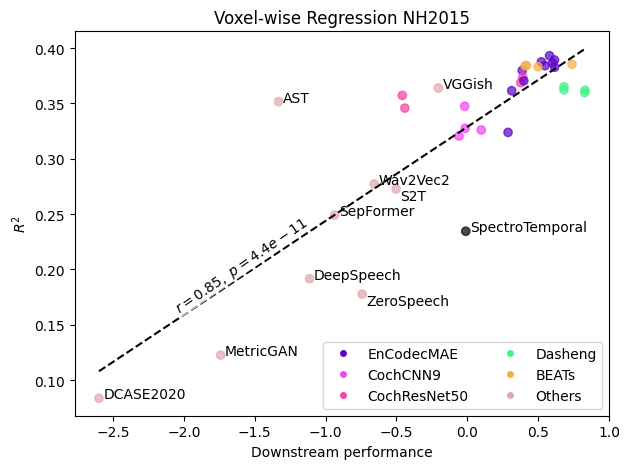

In [17]:
plt.figure()
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'rsa_NH2015_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      xlabel='Downstream performance',
                      ylabel='$\\rho$')
plt.ylim(0.17,0.58)
plt.title('RSA NH2015')
plt.tight_layout()
plt.savefig('corr_rsa_nh2015.pdf')

plt.figure()
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'rsa_B2021_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      xlabel='Downstream performance',
                      ylabel='$\\rho$')
plt.ylim(0.17,0.58)
plt.title('RSA B2021')
plt.tight_layout()
plt.savefig('corr_rsa_b2021.pdf')

plt.figure()
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'REG_NH2015_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      xlabel='Downstream performance',
                      ylabel='$R^2$')
plt.title('Voxel-wise Regression NH2015')
plt.tight_layout()
plt.savefig('corr_reg_nh2015.pdf')

In [3]:
def get_layer_homogeneity(results_path, model, dataset='B2021'):
    rsa_path = Path(results_path, model, f'RSA_{dataset}.pkl')
    if rsa_path.exists():
        rsa_b2021 = joblib.load(rsa_path)
        n_layers = len(layer_map[model])
        distribution = np.zeros(n_layers)
        idxs, counts = np.unique(np.array(rsa_b2021['subjects_layer_selection']), return_counts=True)
        idxs = idxs.astype(int)
        distribution[idxs] = counts / np.sum(counts)
    
        return {'max_freq': np.max(distribution), 'unique': len(idxs)/n_layers}
    else:
        return None

dataset = 'B2021'
for model in layer_map:
    mf = get_layer_homogeneity('../rsa_corrected', model, dataset=dataset)
    if mf is not None:
        mff = mf['max_freq']
        un = mf['unique']
        rsa_val = results_df.loc[results_df['model'] == model][f'rsa_{dataset}_mean'].values[0]
        print(f'{model}: MaxFreq: {mff:.3f} - Unique: {un} - RSA: {rsa_val:.3f}')

NameError: name 'results_df' is not defined